# Analysis of Server Logs
This notebook analyzes server logs to identify anomalies, predict failures, enhance security, and optimize performance.

## Step 1: Understanding the Problem

**Log Classification**
Log classification involves categorizing log entries into predefined categories such as errors, warnings, informational messages, etc. This helps in quickly identifying and addressing issues. Efficient log classification can improve system monitoring and troubleshooting.

**BERT (Bidirectional Encoder Representations from Transformers)**
BERT is a powerful transformer-based model designed for understanding natural language. It has been pre-trained on a large corpus of text and can be fine-tuned for specific tasks, such as text classification, by training it on domain-specific data. Using BERT allows us to leverage its deep understanding of language for accurate log classification.

### Objective
Our goal is to fine-tune a pre-trained BERT model to classify Linux logs into meaningful categories. This will help in quickly identifying the nature of log entries and taking appropriate actions.

## Step 2: Preparing the Environment

We will install all the necessary libraries required for this project. These include:

- **PyTorch**: A popular deep learning framework for building and training neural networks.
- **Transformers**: A library by HuggingFace that provides pre-trained transformer models like BERT.
- **Pandas**: A data manipulation library for handling data in DataFrames.
- **Matplotlib and Seaborn**: Libraries for data visualization.
- **Scikit-Learn**: A library for machine learning that includes tools for model evaluation and metrics.

By setting up this environment, we ensure that we have all the tools needed for data processing, model training, and evaluation.

In [32]:
# Install necessary libraries
%conda install pytorch::pytorch torchvision torchaudio -c pytorch
%conda install transformers datasets evaluate accelerate
%conda install pandas matplotlib seaborn ipywidgets
%conda install scikit-learn -c conda-forge scikit-learn
%pip install bertviz

Channels:
 - pytorch
 - defaults
 - conda-forge
Platform: osx-arm64
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.
Channels:
 - defaults
 - conda-forge
 - pytorch
Platform: osx-arm64
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.
Channels:
 - defaults
 - conda-forge
 - pytorch
Platform: osx-arm64
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.
usage: conda [-h] [-v] [--no-plugins] [-V] COMMAND ...
conda: error: unrecognized arguments: scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [33]:
# What version of Python do you have?
import sys
import platform
import torch
import pandas as pd
import sklearn as sk

has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("NVIDIA/CUDA GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

torch.cuda.empty_cache()

Python Platform: macOS-14.5-arm64-arm-64bit
PyTorch Version: 2.3.1

Python 3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:54:21) [Clang 16.0.6 ]
Pandas 2.2.2
Scikit-Learn 1.4.2
NVIDIA/CUDA GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE
Target device is mps


In [34]:
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from IPython.display import display, HTML

## Step 3: Loading and Exploring the Data

**Loading the Log Data**
We will define a function to load the log data from a file. This function reads the log entries into memory, allowing us to process and analyze them. Understanding the content and structure of the logs is crucial for effective preprocessing and classification.

In [35]:
# Load and preprocess log data
def load_logs(file_path):
    with open(file_path, "r") as file:
        logs = file.readlines()
    return logs


# Load the log file
log_file_path = "data/messages_logs/messages"
logs = load_logs(log_file_path)

html_logs = "<br>".join([log.strip() for log in logs[:20]])
display(HTML(f"<div style='font-family: monospace; white-space: pre;'>{html_logs}</div>"))

## Step 4: Preprocessing the Data

### Text Preprocessing
Text preprocessing involves cleaning and preparing text data for modeling. This includes:

- **Removing unnecessary characters**: Such as timestamps and punctuation that do not contribute to the meaning of the log entries.
- **Tokenization**: Splitting the text into individual words or tokens.
- **Converting text to lowercase**: To ensure uniformity and reduce the vocabulary size.

Preprocessing helps in standardizing the text data, making it suitable for input into the BERT model.

In [36]:
# Define the classification labels
labels = {
    "Time and Date": ["chronyd", "timedatectl"],
    "Service/Process Start and Stop": [
        "systemd",
        "Started",
        "Starting",
        "Stopped",
        "Stopping",
    ],
    "Errors and Warnings": ["error", "fail", "warn", "critical"],
    "System Activity": ["system activity", "accounting", "logrotate", "dnf"],
    "Security": ["promtail", "file watcher", "CREATE", "DELETE"],
    "Network Issues": ["network", "connection", "timeout", "unreachable"],
    "System Configuration": ["kernel", "BIOS", "config"],
}

# Include 'Uncategorized' in the labels
labels["Uncategorized"] = []


def preprocess_log(log):
    # Remove timestamps and other unnecessary characters
    log = re.sub(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}", "", log)  # Remove timestamps
    log = re.sub(r"[^\w\s]", "", log)  # Remove punctuation
    log = log.lower()  # Convert to lowercase
    return log


# Function to categorize log entries
def categorize_log(log_entry):
    for label, keywords in labels.items():
        if any(keyword in preprocess_log(log_entry) for keyword in keywords):
            return label
    return "Uncategorized"


# Apply categorization to logs
labeled_logs = [(log, categorize_log(log)) for log in logs]

# Convert to DataFrame
df = pd.DataFrame(labeled_logs, columns=["Log", "Category"])

# Display the first few labeled logs
df.head()

,Log,Category
0,Jun 27 05:11:51 web01 chronyd[733]: Forward ti...,Time and Date
1,Jun 27 05:11:51 web01 systemd[1]: Started Insi...,Service/Process Start and Stop
2,Jun 27 05:11:51 web01 systemd[1]: Starting sys...,Service/Process Start and Stop
3,Jun 27 05:11:51 web01 systemd[1]: Starting Gen...,Service/Process Start and Stop
4,Jun 27 05:11:51 web01 systemd[1]: Starting dnf...,Service/Process Start and Stop


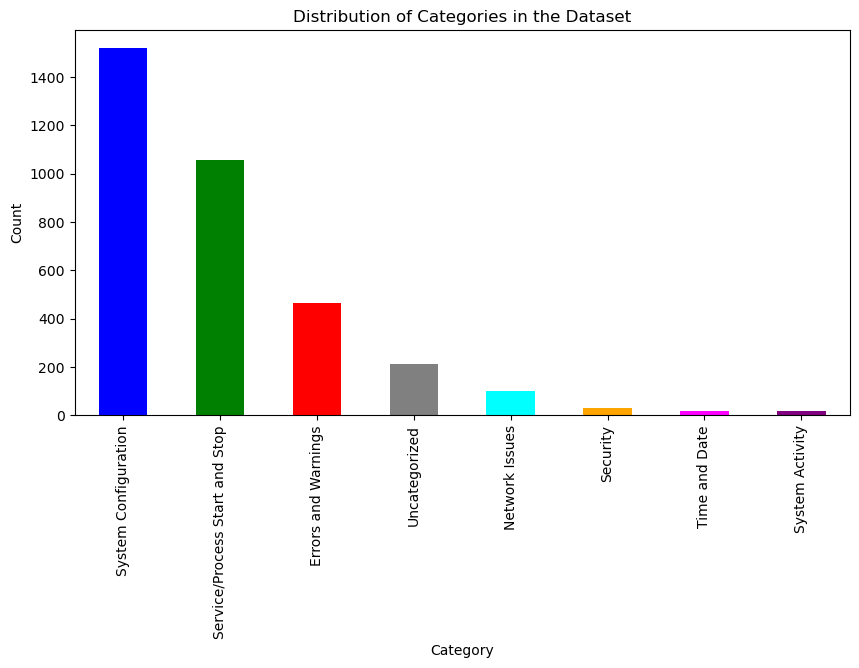

In [37]:
# Assuming 'df' is your DataFrame containing the logs and their categories
category_counts = df["Category"].value_counts()

# Define a color map for the categories
category_colors = {
    "Time and Date": "magenta",
    "Service/Process Start and Stop": "green",
    "Errors and Warnings": "red",
    "System Activity": "purple",
    "Security": "orange",
    "Network Issues": "cyan",
    "System Configuration": "blue",
    "Uncategorized": "grey",
}

# Map colors to the category counts
colors = [category_colors[cat] for cat in category_counts.index]

# Plot the distribution
category_counts.plot(kind="bar", figsize=(10, 5), color=colors)
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Distribution of Categories in the Dataset")
plt.show()

## Step 5: Preparing Data for BERT

### Data Preparation
We will prepare the data for modeling by converting the text data into a format that the BERT model can understand. This involves:

- **Vectorizing the text data**: Tokenizing the text and converting it into numerical representations using the BERT tokenizer.
- **Converting labels to indices**: Mapping each category to a numerical label.

This preparation ensures that our data is compatible with the BERT model for training and prediction.

In [38]:
# Define the label mapping
label_to_id = {label: idx for idx, label in enumerate(labels.keys())}
df["Label"] = df["Category"].apply(lambda x: label_to_id[x])

# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Load pre-trained DistilBert tokenizer
# tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the dataset
train_encodings = tokenizer(list(train_df["Log"]), truncation=True, padding=True)
test_encodings = tokenizer(list(test_df["Log"]), truncation=True, padding=True)

/opt/miniconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [39]:
class LogDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = LogDataset(train_encodings, list(train_df["Label"]))
test_dataset = LogDataset(test_encodings, list(test_df["Label"]))

## Step 6: Fine-Tuning BERT

### Model Training
We will train the BERT model on our labeled log data. Fine-tuning involves adjusting the pre-trained BERT model's parameters to better fit our specific task of log classification. This step includes:

- **Setting training arguments**: Defining parameters like the number of training epochs, batch size, and learning rate.
- **Training the model**: Using our prepared dataset to fine-tune the BERT model.

By fine-tuning, we adapt the BERT model to understand and classify our specific log data more accurately.

In [40]:
import numpy as np

# model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_to_id), output_attentions=True)
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=len(label_to_id)
)
model.to(device)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)

# Define a function to compute metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    accuracy = np.sum(preds == labels) / len(labels)
    return {"accuracy": accuracy}


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/miniconda3/lib/python3.12/site-packages/accelerate/accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


  0%|          | 0/1026 [00:00<?, ?it/s]

{'loss': 2.3622, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.03}
{'loss': 2.2678, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.06}
{'loss': 2.0749, 'learning_rate': 3e-06, 'epoch': 0.09}
{'loss': 1.8837, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.12}
{'loss': 1.6977, 'learning_rate': 5e-06, 'epoch': 0.15}
{'loss': 1.6041, 'learning_rate': 6e-06, 'epoch': 0.18}
{'loss': 1.5839, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.2}
{'loss': 1.3793, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.23}
{'loss': 1.383, 'learning_rate': 9e-06, 'epoch': 0.26}
{'loss': 1.0923, 'learning_rate': 1e-05, 'epoch': 0.29}
{'loss': 1.0724, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.32}
{'loss': 0.8566, 'learning_rate': 1.2e-05, 'epoch': 0.35}
{'loss': 0.7517, 'learning_rate': 1.3000000000000001e-05, 'epoch': 0.38}
{'loss': 0.5709, 'learning_rate': 1.4000000000000001e-05, 'epoch': 0.41}
{'loss': 0.4934, 'learning_rate': 1.5e-05, 'epoch': 0.44}
{'loss': 0.381, 'learning

Checkpoint destination directory ./results/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'loss': 0.1806, 'learning_rate': 5e-05, 'epoch': 1.46}
{'loss': 0.1115, 'learning_rate': 4.904942965779468e-05, 'epoch': 1.49}
{'loss': 0.0458, 'learning_rate': 4.8098859315589354e-05, 'epoch': 1.52}
{'loss': 0.0854, 'learning_rate': 4.714828897338403e-05, 'epoch': 1.55}
{'loss': 0.0897, 'learning_rate': 4.619771863117871e-05, 'epoch': 1.58}
{'loss': 0.0088, 'learning_rate': 4.524714828897338e-05, 'epoch': 1.61}
{'loss': 0.0929, 'learning_rate': 4.4296577946768064e-05, 'epoch': 1.64}
{'loss': 0.0592, 'learning_rate': 4.334600760456274e-05, 'epoch': 1.67}
{'loss': 0.0124, 'learning_rate': 4.2395437262357415e-05, 'epoch': 1.7}
{'loss': 0.1714, 'learning_rate': 4.144486692015209e-05, 'epoch': 1.73}
{'loss': 0.0102, 'learning_rate': 4.0494296577946774e-05, 'epoch': 1.75}
{'loss': 0.0573, 'learning_rate': 3.954372623574145e-05, 'epoch': 1.78}
{'loss': 0.0033, 'learning_rate': 3.8593155893536125e-05, 'epoch': 1.81}
{'loss': 0.0095, 'learning_rate': 3.76425855513308e-05, 'epoch': 1.84}
{'los

Checkpoint destination directory ./results/checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'loss': 0.0068, 'learning_rate': 2.4714828897338406e-06, 'epoch': 2.92}
{'loss': 0.0054, 'learning_rate': 1.5209125475285172e-06, 'epoch': 2.95}
{'loss': 0.1945, 'learning_rate': 5.70342205323194e-07, 'epoch': 2.98}
{'train_runtime': 318.8142, 'train_samples_per_second': 25.736, 'train_steps_per_second': 3.218, 'train_loss': 0.2762812268802239, 'epoch': 3.0}


TrainOutput(global_step=1026, training_loss=0.2762812268802239, metrics={'train_runtime': 318.8142, 'train_samples_per_second': 25.736, 'train_steps_per_second': 3.218, 'train_loss': 0.2762812268802239, 'epoch': 3.0})

## Step 7: Evaluate the Model

**Model Evaluation**: We will evaluate the model's performance on the test set using various metrics to understand how well it classifies log entries.

**Metrics Explanation**:
- **Accuracy**: The ratio of correctly predicted instances to the total instances. It provides an overall measure of model performance.
- **Precision**: The ratio of correctly predicted positive observations to the total predicted positives. High precision indicates low false positive rate.
- **Recall**: The ratio of correctly predicted positive observations to all observations in the actual class. High recall indicates low false negative rate.
- **F1 Score**: The weighted average of Precision and Recall, balancing both metrics.

Evaluating these metrics helps in assessing the strengths and weaknesses of our model.

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

Accuracy: 0.9956
Precision: 0.9957
Recall: 0.9956
F1 Score: 0.9956
                                precision    recall  f1-score   support

                 Time and Date       1.00      1.00      1.00         5
Service/Process Start and Stop       1.00      1.00      1.00       212
           Errors and Warnings       1.00      0.99      0.99        82
               System Activity       1.00      1.00      1.00         4
                      Security       1.00      1.00      1.00         6
                Network Issues       0.94      0.94      0.94        16
          System Configuration       1.00      1.00      1.00       313
                 Uncategorized       0.96      1.00      0.98        46

                      accuracy                           1.00       684
                     macro avg       0.99      0.99      0.99       684
                  weighted avg       1.00      1.00      1.00       684



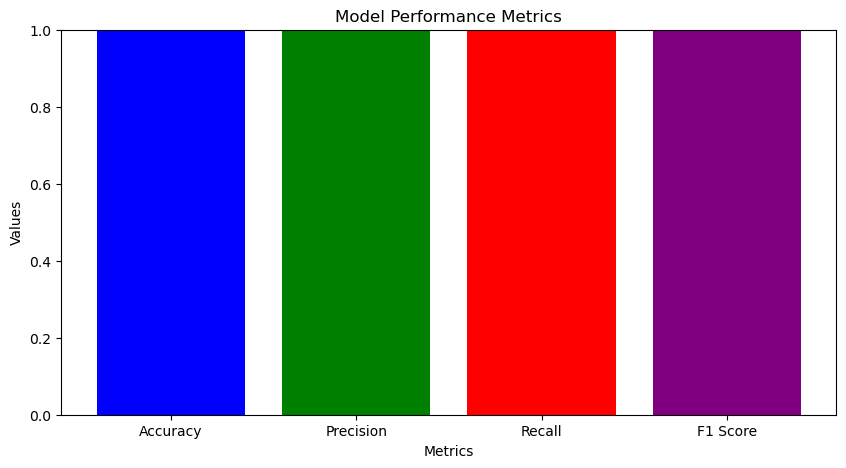

In [41]:
# Empty the cache
torch.cuda.empty_cache()

# Evaluate the model
eval_results = trainer.evaluate()

predictions, labels, _ = trainer.predict(test_dataset)
predicted_labels = predictions.argmax(axis=1)

accuracy = accuracy_score(labels, predicted_labels)
precision = precision_score(labels, predicted_labels, average="weighted")
recall = recall_score(labels, predicted_labels, average="weighted")
f1 = f1_score(labels, predicted_labels, average="weighted")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(classification_report(labels, predicted_labels, target_names=label_to_id.keys()))

# Plot model metrics
metrics = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
}
names = list(metrics.keys())
values = list(metrics.values())

plt.figure(figsize=(10, 5))
plt.bar(names, values, color=["blue", "green", "red", "purple"])
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.ylim(0, 1)
plt.title("Model Performance Metrics")
plt.show()

### Step 9: Confusion Matrix

A **Confusion Matrix** is a summary of prediction results on a classification problem. It shows how well the model's predictions match the actual categories of the data. Here’s a breakdown of what each part of the matrix represents:

- **True Positives (TP)**: The number of instances that were correctly predicted as belonging to a particular category.
- **True Negatives (TN)**: The number of instances that were correctly predicted as not belonging to a particular category.
- **False Positives (FP)**: The number of instances that were incorrectly predicted as belonging to a particular category.
- **False Negatives (FN)**: The number of instances that were incorrectly predicted as not belonging to a particular category.

The confusion matrix helps in understanding the performance of the classification model by showing which categories are often confused with each other.

In the matrix:
- The rows represent the actual categories.
- The columns represent the predicted categories.
- Each cell in the matrix shows the number of instances for a specific combination of actual and predicted categories.

The heatmap visualization makes it easier to see patterns and areas where the model might be struggling. For example, if the model frequently confuses two categories, their corresponding cells will have higher values.

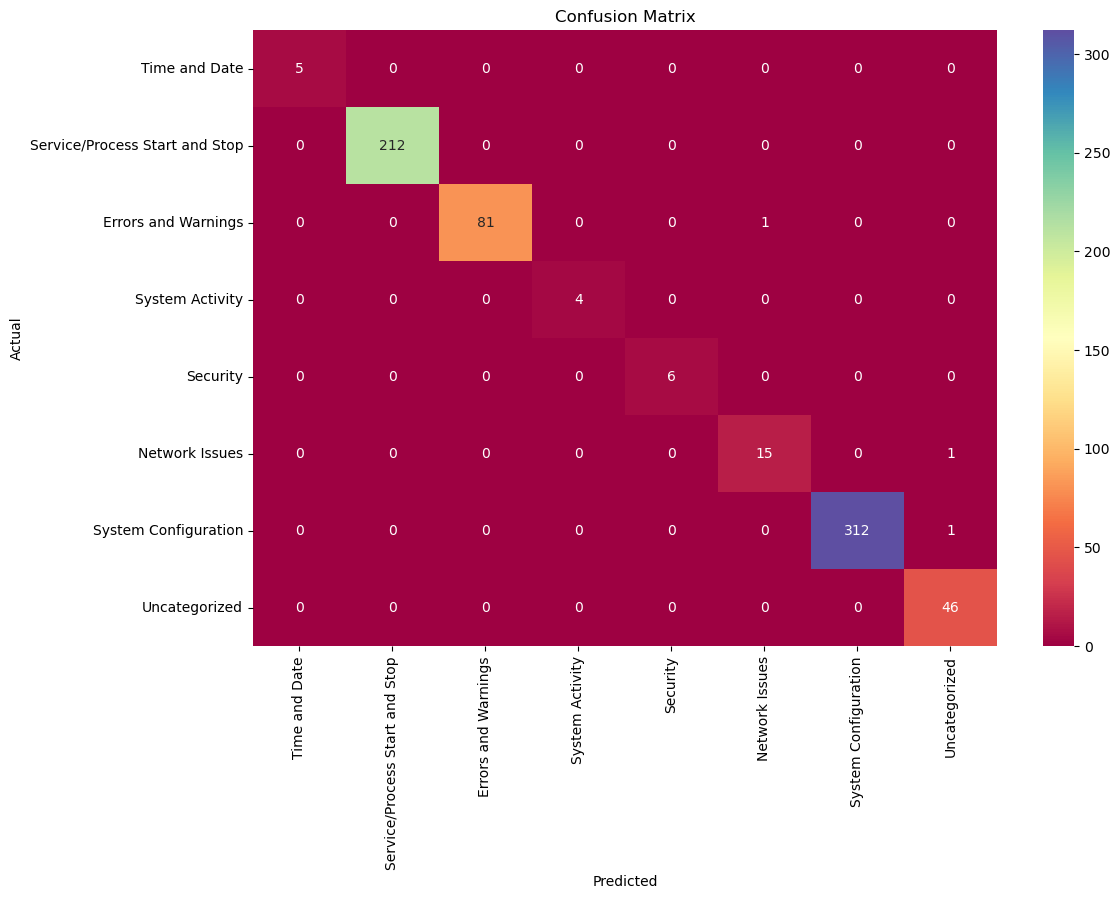

In [42]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(labels, predicted_labels)

plt.figure(figsize=(12, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Spectral",
    xticklabels=label_to_id.keys(),
    yticklabels=label_to_id.keys(),
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Step 9: Save the Trained Model

**Saving the Model**:
We will save the trained model's state dictionary so that it can be loaded and used later.

In [43]:
# Save the trained model's state dictionary
model_save_path = "log_classifier_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to log_classifier_model.pth
